In [4]:
import requests
import json
from langchain import vectorstores, document_loaders, embeddings, chat_models, chains, prompts
import numpy as np
import matplotlib.pyplot as plt
import faiss  # Ensure faiss is imported
from dotenv import load_dotenv
import os
from langchain import vectorstores, document_loaders, embeddings, chat_models, chains, prompts
from langchain.vectorstores import FAISS

from langchain_community.embeddings import OpenAIEmbeddings


# Replace 'vik-gpt-core' with the name of your Solr core
ada_faiss = "../faiss_db/faiss-db-ada-002"
new_faiss = "../faiss_db/faiss-db-text-embedding-3-large"
ada_embedding_model = 'text-embedding-ada-002'
new_embedding_model = 'text-embedding-3-large'
gpt3_model_name = 'gpt-3.5-turbo-1106'

core_name = "vik-gpt-core"
solr_url = f"http://localhost:8983/solr/{core_name}/select"

path_to_test_set = "./tad-qa-dataset/one-course-dataset.json"
path_to_test_set_difficult = "./tad-qa-dataset/one-course-dataset-difficult.json"

llm_gpt3 = chat_models.ChatOpenAI(model_name=gpt3_model_name, temperature=0.0)
embeddings_ada = OpenAIEmbeddings(model=ada_embedding_model)
embeddings_new = OpenAIEmbeddings(model=new_embedding_model)

vectorstore_ada = FAISS.load_local(ada_faiss, embeddings_ada, allow_dangerous_deserialization=True)
vectorstore_new = FAISS.load_local(new_faiss, embeddings_new, allow_dangerous_deserialization=True)


In [5]:
solr_color = '#8bd7b3'
solr_llm_color = '#17af68'
embed_color = '#77ace9'
embed_color_new = '#a7bcf9'

In [6]:
vectorstore_ada.max_marginal_relevance_search('paragrafus',)

[Document(page_content='231. §  464[Értelmező rendelkezések ] \nJelen  Szabályzat alkalmazásában  \n1. abszolutórium : lásd végbizonyítvány;  \n1a. 465adatkezelő : amennyiben uniós vagy tagállami jogszabály másként nem rendelkezik, akkor az általa kezelt személyes adatok céljainak és eszközei nek \n \n464 A szakasz címét megállapította az V./3./2019 -2020. számú Szenátusi határozat. Hatályos 2020. január 31 -től. \n465 Beiktatta a X./5./2017 -2018. számú Szenátusi határozat. Hatályos  2018. augusztus 1 -től.\n150 önállóan vagy másokkal együttesen történő meghatározása alapján az \nEgyetem; jelen Szabályzat alkalmazásában az adatkezelést végző személyt \nis adatkezelőnek kell tekinteni;  \n1b. 466adatkezelés: a személyes adatokon vagy adatállományokon automatizált \nvagy nem automatizált módon végzett bármely művelet vagy műveletek \nösszessége, így a gyűjtés, rögzítés, rendszerezés, tagolás, tárolás, átalakítás \nvagy megváltoztatás, lekérdezés, betekintés, felhasználás, közlés, tovább

In [7]:
with open(path_to_test_set, "r", encoding="utf-8") as f:
    test_set = json.load(f)

def get_title(tad):
    try:
        return tad.split('\n')[0].split('-')[1].strip()
    except Exception:
        return ""

In [8]:
params = {
    "q": "analizis",
    "defType": "edismax",
    "qf": "page_content_t",
    "wt": "json",
    "rows": 10,  # Request the maximum rows once
}
response = requests.get(solr_url, params=params)
if response.status_code == 200:
    response_json = response.json()
    documents = response_json.get("response", {}).get("docs", [])
response_json

{'responseHeader': {'status': 0,
  'QTime': 36,
  'params': {'q': 'analizis',
   'defType': 'edismax',
   'qf': 'page_content_t',
   'rows': '10',
   'wt': 'json'}},
 'response': {'numFound': 1,
  'start': 0,
  'numFoundExact': True,
  'docs': [{'id': 'b065b8c0-db52-4678-9f9f-4c5abb8851cc',
    'data_type_s': 'tad_page',
    'source_s': 'https://portal.vik.bme.hu/kepzes/targyak/TE110909/',
    'page_content_t': 'BME VIK - Fizikai problémák megoldása villamosmérnökök számára 3\nBudapest University of Technology and Economics, Faculty of Electrical Engineering and Informatics\nFizikai problémák megoldása villamosmérnökök számára 3\nBelépés\ncímtáras azonosítással\ntantárgyi adatlapok\nmagyar nyelvű adatlap\nvissza a tantárgylistához\nnyomtatható verzió\nFizikai problémák megoldása villamosmérnökök számára 3\nA tantárgy angol neve: Physics in Practice for Electrical Engineers 3\nAdatlap utolsó módosítása: 2006. július 1.\nBudapesti Műszaki és Gazdaságtudományi Egyetem\nVillamosmérnöki és 

In [9]:
text = response_json.get("response", {}).get("docs", [])[0]['page_content_t']
get_title(text)

'Fizikai problémák megoldása villamosmérnökök számára 3'

In [10]:
import matplotlib.pyplot as plt

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        query = question["question"]
        params = {
            "q": query,
            "defType": "edismax",
            "qf": "page_content_t",
            "wt": "json",
            "rows": 10,  # Request the maximum rows once
        }
        response = requests.get(solr_url, params=params)
        if response.status_code == 200:
            response_json = response.json()
            documents = response_json.get("response", {}).get("docs", [])
            titles = [get_title(doc['page_content_t']) for doc in documents]
            
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1

accuracies_solr_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]


In [11]:
accuracies_solr_easy

[0.31891891891891894,
 0.4648648648648649,
 0.5135135135135135,
 0.5459459459459459,
 0.5837837837837838,
 0.6270270270270271,
 0.6378378378378379,
 0.654054054054054,
 0.6648648648648648,
 0.6702702702702703]

In [12]:
titles

['IT a járműgyártásban',
 'IT biztonság laboratórium',
 'Kódolás és IT biztonság',
 'IT biztonság',
 'Szoftverbiztonság',
 'Adatbiztonság a gazdaságinformatikában',
 'Számítógép',
 'Szoftverfejlesztés az iparban',
 'IT üzemeltetés',
 '']

In [13]:
import matplotlib.pyplot as plt
results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        query = question["question"]
        docs = vectorstore_ada.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
        titles = [get_title(doc.page_content) for doc in docs]
        for n in range(1, 11):
            if title_target in titles[:n]:
                results[n]['correct'] += 1
            results[n]['total'] += 1

accuracies_embed_ada_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]


In [14]:
import matplotlib.pyplot as plt
results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        query = question["question"]
        docs = vectorstore_new.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
        titles = [get_title(doc.page_content) for doc in docs]
        for n in range(1, 11):
            if title_target in titles[:n]:
                results[n]['correct'] += 1
            results[n]['total'] += 1

accuracies_embed_new_easy = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]


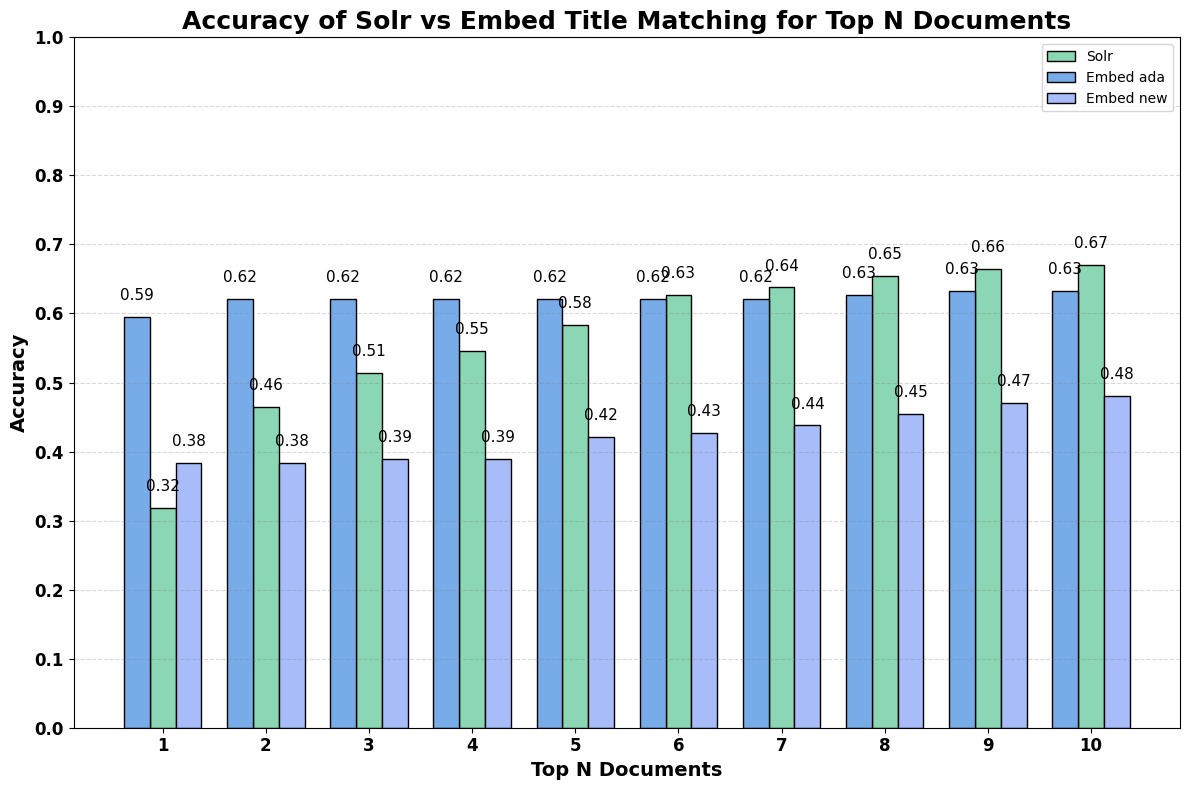

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)  # Array from 1 to 10 for the x-axis

bar_width = 0.25  # Adjusted for 3 bars
positions_embed = n_documents - bar_width  # Left bar
positions_solr = n_documents  # Middle bar
positions_solr_llm = n_documents + bar_width  # Right bar

# Plotting both sets of accuracies
plt.bar(positions_solr, accuracies_solr_easy, width=bar_width, color=solr_color, edgecolor='black', linewidth=1, alpha=1, label='Solr')
plt.bar(positions_embed, accuracies_embed_ada_easy, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed ada')
plt.bar(positions_solr_llm, accuracies_embed_new_easy, width=bar_width, color=embed_color_new, edgecolor='black', linewidth=1, alpha=1, label='Embed new')

plt.title('Accuracy of Solr vs Embed Title Matching for Top N Documents', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')

plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')

plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')


# Adding value labels on top of each bar
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_solr_easy[i] + 0.02, f"{accuracies_solr_easy[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_embed_ada_easy[i] + 0.02, f"{accuracies_embed_ada_easy[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_solr_llm[i], accuracies_embed_new_easy[i] + 0.02, f"{accuracies_embed_new_easy[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')

plt.legend()
plt.tight_layout()
plt.show()


In [16]:
with open(path_to_test_set_difficult, "r", encoding="utf-8") as f:
    test_set = json.load(f)

In [17]:

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}
for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        for query in [question["difficult"], question['question']]:
        # query = question["difficult"]
            params = {
                "q": query,
                "defType": "edismax",
                "qf": "page_content_t",
                "wt": "json",
                "rows": 10,  # Request the maximum rows once
            }
            response = requests.get(solr_url, params=params)
            if response.status_code == 200:
                response_json = response.json()
                documents = response_json.get("response", {}).get("docs", [])
                titles = [get_title(doc['page_content_t']) for doc in documents]
                
                for n in range(1, 11):
                    if title_target in titles[:n]:
                        results[n]['correct'] += 1
                    results[n]['total'] += 1
accuracies_solr_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}
for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        for query in [question["difficult"], question['question']]:
            docs = vectorstore_ada.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
            titles = [get_title(doc.page_content) for doc in docs]
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1
accuracies_embed_ada_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}
for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    
    for question in example["questions"]:
        for query in [question["difficult"], question['question']]:
            docs = vectorstore_new.max_marginal_relevance_search(query=query, k=10, fetch_k=50)
            titles = [get_title(doc.page_content) for doc in docs]
            for n in range(1, 11):
                if title_target in titles[:n]:
                    results[n]['correct'] += 1
                results[n]['total'] += 1
accuracies_embed_new_difficult = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]



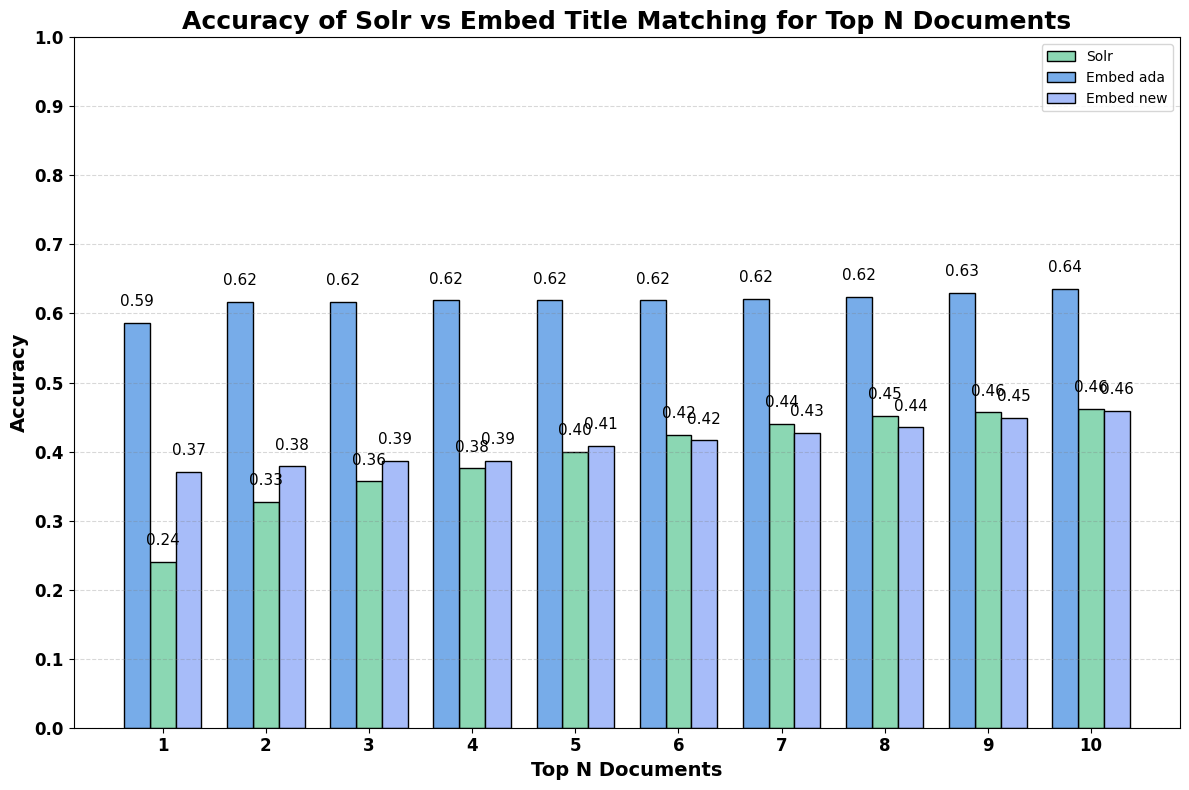

In [18]:
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)  # Array from 1 to 10 for the x-axis

bar_width = 0.25  # Adjusted for 3 bars
positions_embed = n_documents - bar_width  # Left bar
positions_solr = n_documents  # Middle bar
positions_solr_llm = n_documents + bar_width  # Right bar

# Plotting both sets of accuracies
plt.bar(positions_solr, accuracies_solr_difficult, width=bar_width, color=solr_color, edgecolor='black', linewidth=1, alpha=1, label='Solr')
plt.bar(positions_embed, accuracies_embed_ada_difficult, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed ada')
plt.bar(positions_solr_llm, accuracies_embed_new_difficult, width=bar_width, color=embed_color_new, edgecolor='black', linewidth=1, alpha=1, label='Embed new')

plt.title('Accuracy of Solr vs Embed Title Matching for Top N Documents', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')

plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')

plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')


# Adding value labels on top of each bar
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_solr_difficult[i] + 0.02, f"{accuracies_solr_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_embed_ada_difficult[i] + 0.02, f"{accuracies_embed_ada_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_solr_llm[i], accuracies_embed_new_difficult[i] + 0.02, f"{accuracies_embed_new_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')

plt.legend()
plt.tight_layout()
plt.show()


In [19]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate

query = "Milyen tárgyat tanít Mészáros Tamás?"
qa = PromptTemplate.from_template(
    template=(
        'Your task is to extract the keywords of the user query and optionally add keywords if you find them relevant.'
        'Make sure it is in Hungarian, use at most 3 keywords'
        'Example: Milyen játékelméletről szóló tárgyak vannak?'
        'Output: játékelmélet, nash egyensúly, fogolydilemma'
        'Task: {query}'
        'Output:'
    )
)
chain = qa | llm_gpt3
result = chain.invoke({'query': query}).content
print(result)
params = {
    "q": result,  # Use the raw query without field specification
    "defType": "edismax",  # Use the Extended DisMax query parser
    "qf": "page_content_t",  # Query fields with weights (adjust as needed)
    "wt": "json",  # Response format (json)
    "rows": 10,    # Number of rows to return
}

# Make the HTTP GET request to Solr
response = requests.get(solr_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the response JSON
    response_json = response.json()
    # Extract documents from the response
    documents = response_json.get("response", {}).get("docs", [])
    
    # Print the documents
    print(f"Found {len(documents)} documents matching the query '{query}':")
    # for doc in documents:
    #     print(json.dumps(doc, indent=2))
    # _ = [print(i['title_t']) for i in documents]
else:
    print("Failed to query Solr:", response.text)

Mészáros Tamás, tárgy, tanítás
Found 10 documents matching the query 'Milyen tárgyat tanít Mészáros Tamás?':


In [20]:
import matplotlib.pyplot as plt

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    for question in example["questions"]:
         for query in [question["difficult"], question['question']]:
            params = {
                "q": chain.invoke({'query': query}).content,
                "defType": "edismax",
                "qf": "page_content_t",
                "wt": "json",
                "rows": 10,  # Request the maximum rows once
            }
            response = requests.get(solr_url, params=params)
            if response.status_code == 200:
                response_json = response.json()
                documents = response_json.get("response", {}).get("docs", [])
                titles = [get_title(doc['page_content_t']) for doc in documents]
                
                for n in range(1, 11):
                    if title_target in titles[:n]:
                        results[n]['correct'] += 1
                    results[n]['total'] += 1
    
accuracies_solr_difficult_llm = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

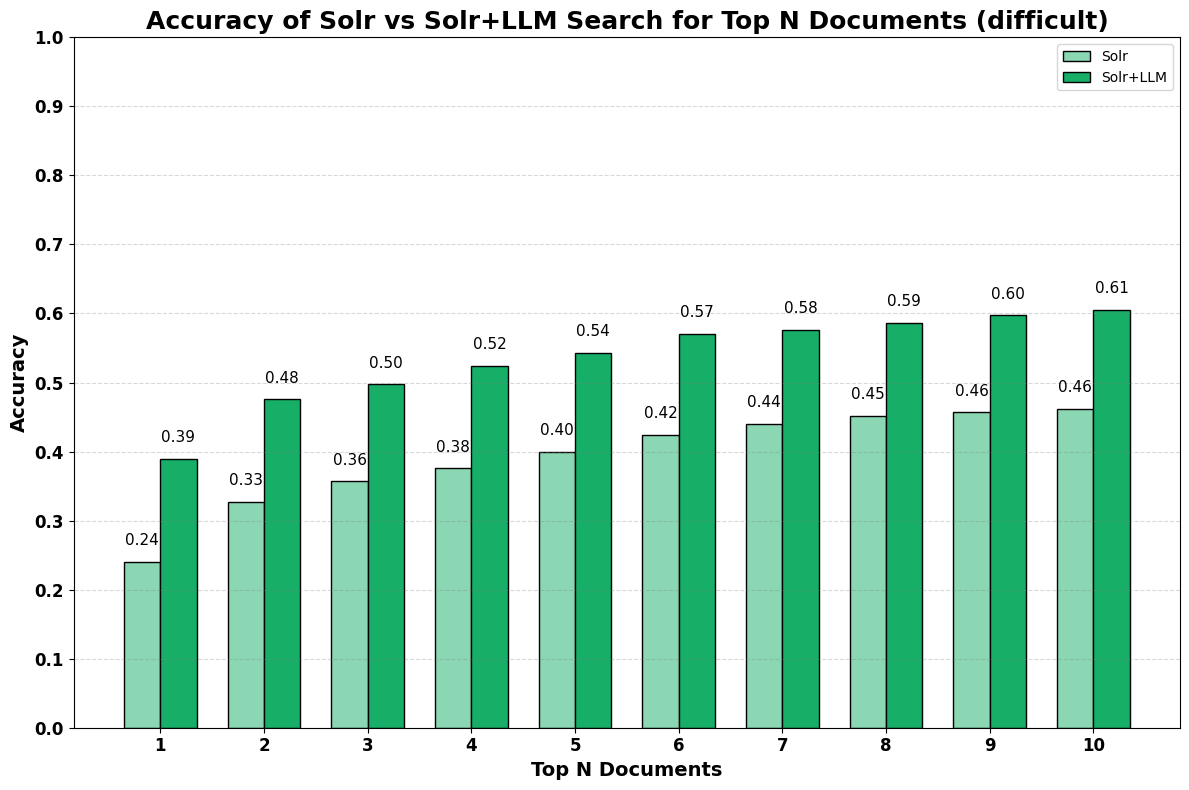

In [21]:
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.35
positions_solr = n_documents - bar_width/2
positions_embed = n_documents + bar_width/2
plt.bar(positions_solr, accuracies_solr_difficult, width=bar_width, color=solr_color, edgecolor='black', linewidth=1, alpha=1, label='Solr')
plt.bar(positions_embed, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Solr vs Solr+LLM Search for Top N Documents (difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_solr_difficult[i] + 0.02, f"{accuracies_solr_difficult[i]:.2f}", ha='center', va='bottom',fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom',fontsize=11, color='black')
plt.legend()
plt.tight_layout()
plt.show()

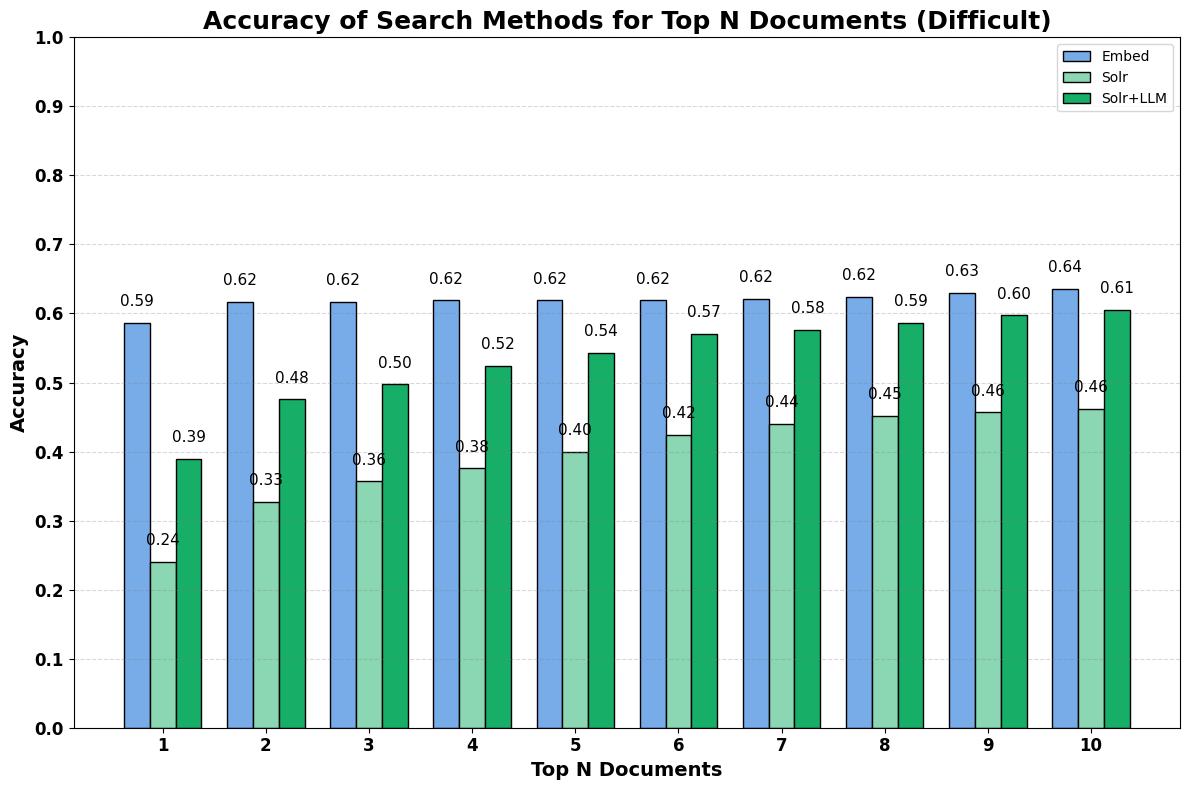

In [22]:
# Set up for the plot
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.25  # Adjusted for 3 bars
positions_embed = n_documents - bar_width  # Left bar
positions_solr = n_documents  # Middle bar
positions_solr_llm = n_documents + bar_width  # Right bar

# Plotting
plt.bar(positions_embed, accuracies_embed_ada_difficult, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed')
plt.bar(positions_solr, accuracies_solr_difficult, width=bar_width, color=solr_color, edgecolor='black', linewidth=1, alpha=1, label='Solr')
plt.bar(positions_solr_llm, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Search Methods for Top N Documents (Difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')

# # Adding value labels on top of each bar
for i in range(len(n_documents)):
    plt.text(positions_embed[i], accuracies_embed_ada_difficult[i] + 0.02, f"{accuracies_embed_ada_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_solr[i], accuracies_solr_difficult[i] + 0.02, f"{accuracies_solr_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_solr_llm[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')

plt.legend()
plt.tight_layout()

plt.show()

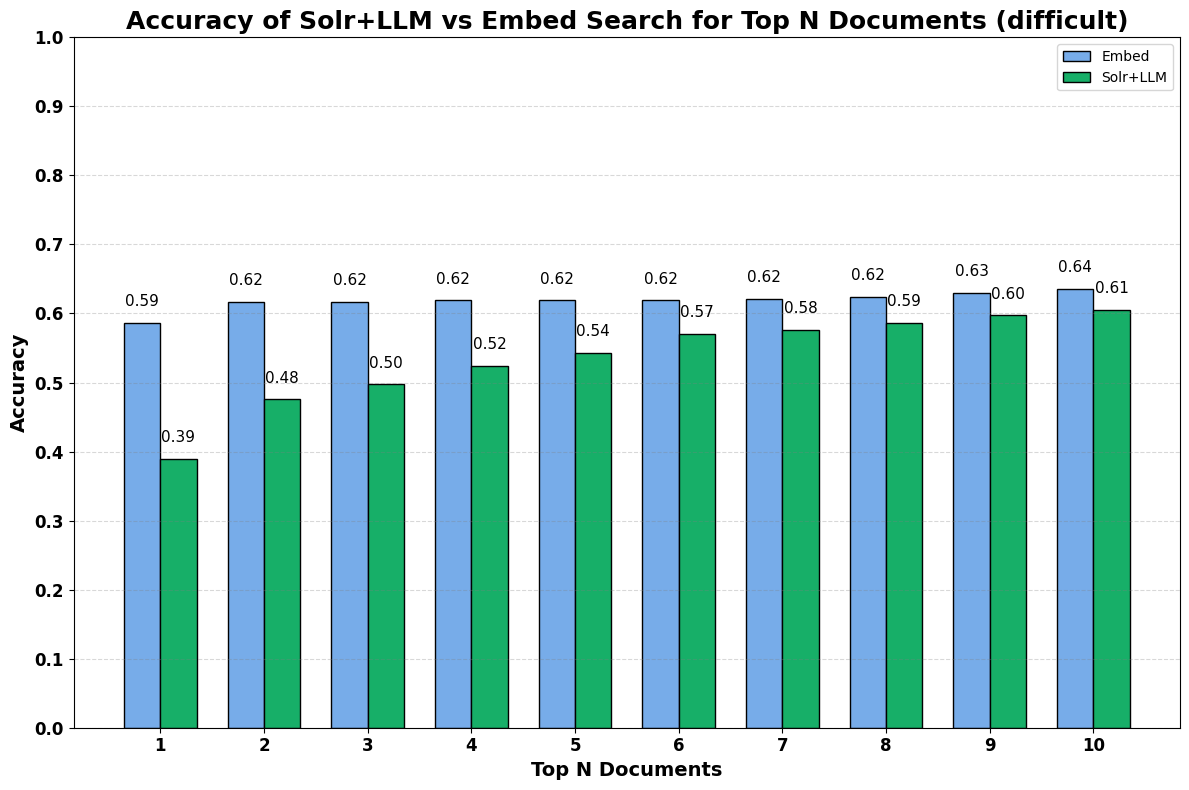

In [23]:
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.35
positions_solr = n_documents - bar_width/2
positions_embed = n_documents + bar_width/2
plt.bar(positions_solr, accuracies_embed_ada_difficult, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed')
plt.bar(positions_embed, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Solr+LLM vs Embed Search for Top N Documents (difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')  

plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_embed_ada_difficult[i] + 0.02, f"{accuracies_embed_ada_difficult[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
import matplotlib.pyplot as plt

results = {n: {'correct': 0, 'total': 0} for n in range(1, 11)}

for example in test_set:
    context = example["context"]
    title_target = context.split("\n")[1][len("A kurzus címe: "):-1]
    for question in example["questions"]:
         for query in [question["difficult"], question['question']]:
            params = {
                "q": chain.invoke({'query': query}).content,
                "defType": "edismax",
                "qf": "page_content_t",
                "wt": "json",
                "rows": 8,  # Request the maximum rows once
            }
            response = requests.get(solr_url, params=params)
            if response.status_code == 200:
                response_json = response.json()
                documents = response_json.get("response", {}).get("docs", [])
                docs_vect = vectorstore_ada.max_marginal_relevance_search(query=query, k=2, fetch_k=50)
                titles = [get_title(doc.page_content) for doc in docs_vect]
                titles.append([get_title(doc['page_content_t']) for doc in documents])
                
                
                
                for n in range(1, 11):
                    if title_target in titles[:n]:
                        results[n]['correct'] += 1
                    results[n]['total'] += 1
    
accuracies_solr_emb_difficult_llm = [results[n]['correct'] / results[n]['total'] if results[n]['total'] > 0 else 0 for n in range(1, 11)]

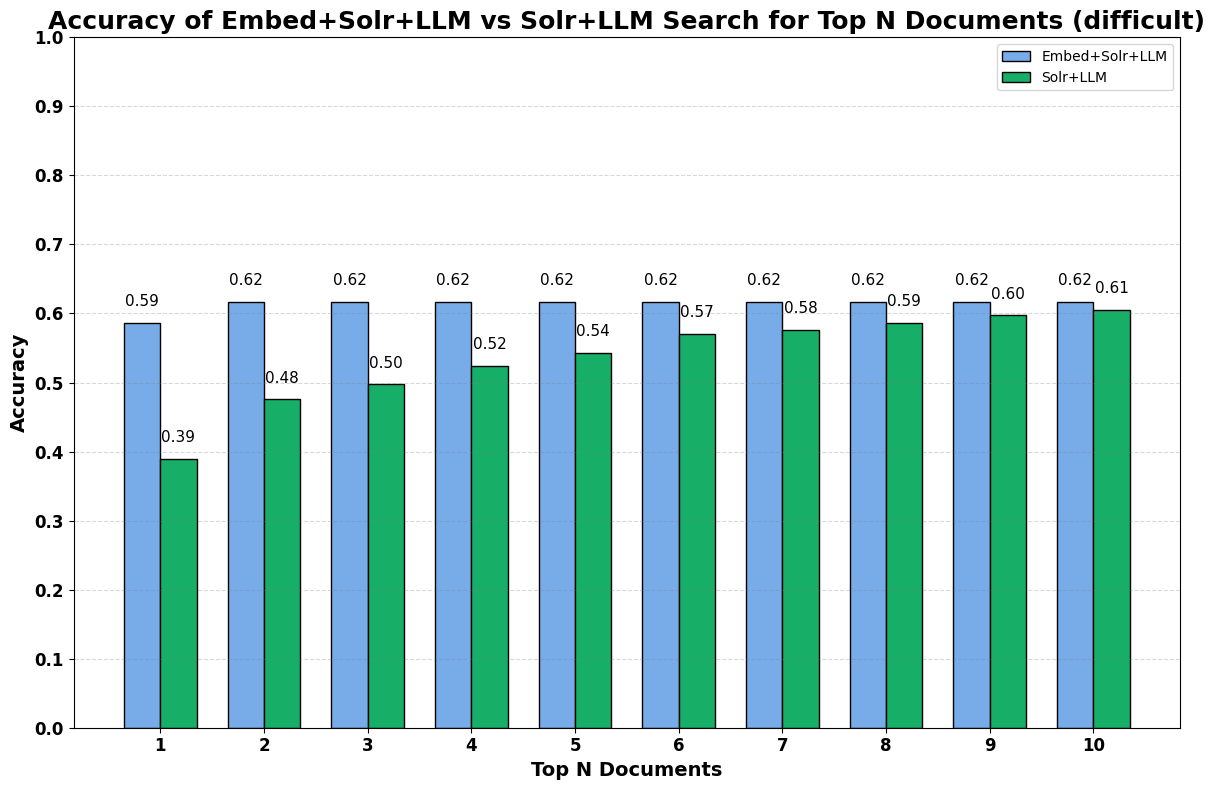

In [25]:
plt.figure(figsize=(12, 8), facecolor='white')
n_documents = np.arange(1, 11)
bar_width = 0.35
positions_solr = n_documents - bar_width/2
positions_embed = n_documents + bar_width/2
plt.bar(positions_solr, accuracies_solr_emb_difficult_llm, width=bar_width, color=embed_color, edgecolor='black', linewidth=1, alpha=1, label='Embed+Solr+LLM')
plt.bar(positions_embed, accuracies_solr_difficult_llm, width=bar_width, color=solr_llm_color, edgecolor='black', linewidth=1, alpha=1, label='Solr+LLM')

plt.title('Accuracy of Embed+Solr+LLM vs Solr+LLM Search for Top N Documents (difficult)', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Top N Documents', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='black')
plt.xticks(n_documents, fontsize=12, fontweight='bold', color='black')
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12, fontweight='bold', color='black')  

plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')
for i in range(len(n_documents)):
    plt.text(positions_solr[i], accuracies_solr_emb_difficult_llm[i] + 0.02, f"{accuracies_solr_emb_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
    plt.text(positions_embed[i], accuracies_solr_difficult_llm[i] + 0.02, f"{accuracies_solr_difficult_llm[i]:.2f}", ha='center', va='bottom', fontsize=11, color='black')
plt.legend()
plt.tight_layout()
plt.show()